In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/pozdn/.wget-hsts'. HSTS will be disabled.
--2020-09-29 04:53:10--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1601348050&Signature=UCA8Eibe0YQK%2FbtFHXVYXlH5xvk%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-09-29 04:53:10--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?respo

In [2]:
import sys
sys.path.insert(0, '../')
import numpy as np
import ase.io
import tqdm
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized
from nice.utilities import make_structural_features
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:100000"    #input for ase.io.read command
test_subset = "3050000:3130000"     #input to ase.io.read command
environments_for_fitting = 5000    #number of environments to fit nice transfomers
grid =   [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000,
          5000, 7500, 10000, 15000, 20000,
          30000, 50000, 75000, 100000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}

In [4]:
#our model:
def get_transformer():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 1000),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(500),
                                                 None,
                                                 None,
                                                  None),
                            StandardBlock(ThresholdExpansioner(num_expand = 3000),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(500),
                                                  ThresholdExpansioner(num_expand = 5000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                 InvariantsPCA(n_components = 1000)),
                             StandardBlock(None,
                                             None,
                                                  None,
                                                  ThresholdExpansioner(num_expand = 5000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(n_components = 2000))
                                   ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True))

In [5]:
train_structures = ase.io.read('methane.extxyz', 
                         index = train_subset)


train_coefficients = get_rascal_coefficients_parallelized(train_structures, HYPERS)

test_structures = ase.io.read('methane.extxyz', 
                         index = test_subset)

test_coefficients = get_rascal_coefficients_parallelized(test_structures, HYPERS)

100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


In [6]:
all_species = []
for structure in train_structures:
    all_species.append(np.array(structure.get_atomic_numbers()))
all_species = np.concatenate(all_species, axis=0)
all_species = np.sort(np.unique(all_species))


In [7]:
#individual transformers for each atomic specie in dataset
transformers = {}
for key in train_coefficients.keys():
    transformers[key] = get_transformer()

In [8]:
for key in train_coefficients.keys():
    transformers[key].fit(train_coefficients[key][:environments_for_fitting])

../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1000, desired number of environments is 10000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 2000, desired number of environments is 20000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1000, desired number of environments is 10000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 2000, desired number of envir

In [9]:
def transform_sequentially(transformers, structures, all_species, 
                           block_size = 500, show_progress = True):
    pieces = []
    
    for i in tqdm.tqdm(range(0, len(structures), block_size), disable = not show_progress):
        now = {}
        coefficients = get_rascal_coefficients_parallelized(structures[i : i + block_size],
                                                            HYPERS,
                                                            show_progress = False)
        for specie in all_species:
            now[specie] = transformers[specie].transform(coefficients[specie],
                                                      return_only_invariants = True)
        pieces.append(make_structural_features(now, structures[i : i + block_size],
                                               show_progress = False))        
    
    return np.concatenate(pieces, axis = 0)

In [10]:
train_features = transform_sequentially(transformers, 
                                        train_structures, all_species)
test_features = transform_sequentially(transformers,
                                        test_structures, all_species)

100%|██████████| 160/160 [1:14:57<00:00, 28.11s/it]


In [11]:
intermediate_shapes = transformers[1].get_intermediate_shapes()
for key in intermediate_shapes.keys():
    print(key, ':',  intermediate_shapes[key], end = '\n\n\n')
    
intermediate_shapes = transformers[6].get_intermediate_shapes()
for key in intermediate_shapes.keys():
    print(key, ':',  intermediate_shapes[key], end = '\n\n\n')
    
del transformers #to free memory

after initial transformer : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


after initial pca : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


block nu = 1 -> nu = 2 : {'after covariants expansioner': [[338, 313, 769, 620, 826, 553], [0, 586, 506, 840, 624, 704]], 'after covariants purifier': [[338, 313, 769, 620, 826, 553], [0, 586, 506, 840, 624, 704]], 'after covariants pca': [[338, 313, 500, 500, 500, 500], [0, 500, 500, 500, 500, 500]]}


block nu = 2 -> nu = 3 : {'after covariants expansioner': [[382, 1361, 1877, 2187, 2198, 1887], [594, 1258, 1892, 2149, 2136, 1862]], 'after covariants purifier': [[382, 1361, 1877, 2187, 2198, 1887], [594, 1258, 1892, 2149, 2136, 1862]], 'after covariants pca': [[382, 500, 500, 500, 500, 500], [500, 500, 500, 500, 500, 500]], 'after invariants expansioner': 5000, 'after invariants purifier': 5000, 'after invariants pca': 1000}


block nu = 3 -> nu = 4 : {'after invariants expansioner': 5000, 'after invariants purifier': 5000, 'after invariant

In [12]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV


In [13]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))

def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values)) ** 2))

def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)

def estimate_performance(clf, data_train, data_test, targets_train, targets_test):
    clf.fit(data_train, targets_train)
    return get_relative_performance(clf.predict(data_test), targets_test)

In [14]:
errors = []
for el in tqdm.tqdm(grid):   
    errors.append(estimate_performance(BayesianRidge(), train_features[:el],
                                       test_features, train_energies[:el],
                                       test_energies))

100%|██████████| 18/18 [23:12<00:00, 77.38s/it] 


In [15]:
print(errors)

[0.4763020684065621, 0.47829365294211107, 0.3816840939713879, 0.2973682008172019, 0.18593569748074176, 0.14893128580968737, 0.12127052250483596, 0.10546646879466677, 0.09589744867815536, 0.07466096362137524, 0.062147638724416025, 0.05541091847240947, 0.04523674098590771, 0.040284117135377114, 0.03525619475788012, 0.03036076602421925, 0.02753305327314648, 0.026121440309616748]


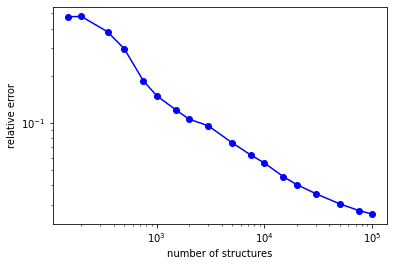

In [16]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
print(train_features.shape)

(100000, 6858)
